In [1]:
# connecting to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
import time
from keras.preprocessing.image import load_img, img_to_array
#from scipy.misc import imsave
import numpy as np
from scipy.optimize import fmin_l_bfgs_b

In [4]:
import imageio
from tqdm import tqdm

In [5]:
from keras.applications import vgg19
from keras import backend as K

## Source images and algorithm parameters 




In [6]:
CONTENT_IMG_PATH = '/content/drive/MyDrive/NeuralStyleWorkDir/fight_club_content.png'
CONTENT_IMG_PATH1 = '/content/drive/MyDrive/NeuralStyleWorkDir/paris_content.jpg'

STYLE_IMG_PATH = '/content/drive/MyDrive/NeuralStyleWorkDir/pablo_picasso_style.jpg'
STYLE_IMG_PATH1 = '/content/drive/MyDrive/NeuralStyleWorkDir/frida_kahlo_style.jpg'

ITERATIONS = 15  # count of iterations
STYLE_WEIGHT = 0.5  # weight of style loss function
CONTENT_WEIGHT = 0.75  # weight of style loss function
VARIATION_WEIGHT = 0.99  # weight od difference between pixels loss function

## Setting size of result image

In [7]:
width, height = load_img(CONTENT_IMG_PATH).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

## Showing source images

Text(0.5, 1.0, 'Content Image(Fight Club)')

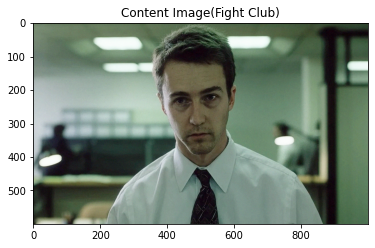

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(plt.imread(CONTENT_IMG_PATH))
plt.title('Content Image(Fight Club)')

Text(0.5, 1.0, 'Content Image(Paris)')

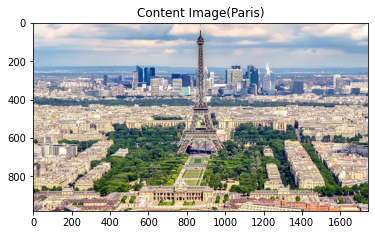

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(plt.imread(CONTENT_IMG_PATH1))
plt.title('Content Image(Paris)')

Text(0.5, 1.0, 'Style Image - Picasso')

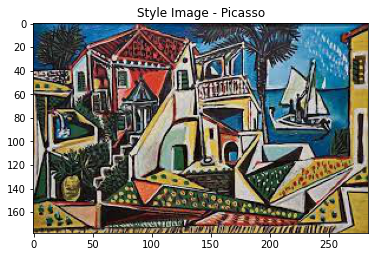

In [ ]:
plt.imshow(plt.imread(STYLE_IMG_PATH))
plt.title('Style Image - Picasso')

Text(0.5, 1.0, 'Style Image - Frida Kahlo')

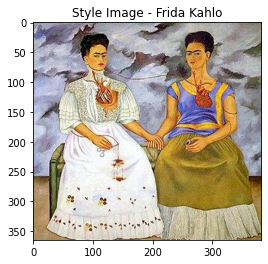

In [ ]:
plt.imshow(plt.imread(STYLE_IMG_PATH1))
plt.title('Style Image - Frida Kahlo')

In [ ]:
# # CHANGE CONTENT AND STYLE
#STYLE_IMG_PATH = STYLE_IMG_PATH1
#CONTENT_IMG_PATH = CONTENT_IMG_PATH1

In [ ]:
# preprocessing image before sending to vgg19
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# transform generated tenstor to image
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # return the offset relative to the mean
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


### This part of a code will be used n times(with diffrent style, content, model)


In [ ]:


# loading image and preprocess before vgg19
base_image = K.variable(preprocess_image(CONTENT_IMG_PATH))
style_reference_image = K.variable(preprocess_image(STYLE_IMG_PATH))

# creating a buffer for saving result
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# combine images into batch
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

# loading neural network
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# #  CHANGING MODEL 
# # easy deleting layers : set weights to zero
# for i in range(2,6):
#   model.layers[-i].set_weights([np.zeros_like(model.layers[-i].get_weights()[0]),np.zeros_like(model.layers[-i].get_weights()[1])])

# output layers dict (full model)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])



Model loaded.


## Setting loss function

In [ ]:
# covariation matrix
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# loss function calculating based on cov matrix
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# loss function for content
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# setting restrictions for difference between pixels
def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

## Combine losses

In [ ]:
loss = K.variable(0.)

# content getting only from block'block5_conv2' 
layer_features = outputs_dict['block5_conv2']

base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + CONTENT_WEIGHT * content_loss(base_image_features, combination_features)

# loss function will be calculated on this layers
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (STYLE_WEIGHT / len(feature_layers)) * sl
    
# add differencer between pixels loss function
loss = loss + VARIATION_WEIGHT * total_variation_loss(combination_image)

## Gradients of the resulting image from the loss function

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution 
tf.compat.v1.disable_eager_execution() 
# calculating funciton gradients
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

# calcilating losses and gradients
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# wrapper for optimizer class
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

## Starting process of stylelization 



In [ ]:
# initialize image
x = preprocess_image(CONTENT_IMG_PATH)

for i in tqdm(range(ITERATIONS)):
    print('Start of iteration', i)
    start_time = time.time()
    # calculating gradients and update values
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save images
    img = deprocess_image(x.copy())
    fname = '/content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_pp_%d.png' % i
    imageio.imwrite(fname, img)
    #imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

  0%|          | 0/15 [00:00<?, ?it/s]

Start of iteration 0


  7%|▋         | 1/15 [00:33<07:48, 33.48s/it]

Current loss value: 11397470000.0
Image saved as /content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_pp_0.png
Iteration 0 completed in 33s
Start of iteration 1


 13%|█▎        | 2/15 [00:56<05:59, 27.62s/it]

Current loss value: 8514362400.0
Image saved as /content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_pp_1.png
Iteration 1 completed in 23s
Start of iteration 2


 20%|██        | 3/15 [01:20<05:10, 25.86s/it]

Current loss value: 7581538300.0
Image saved as /content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_pp_2.png
Iteration 2 completed in 23s
Start of iteration 3


 27%|██▋       | 4/15 [01:44<04:36, 25.10s/it]

Current loss value: 7082370000.0
Image saved as /content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_pp_3.png
Iteration 3 completed in 23s
Start of iteration 4


 33%|███▎      | 5/15 [02:08<04:06, 24.62s/it]

Current loss value: 6821055000.0
Image saved as /content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_pp_4.png
Iteration 4 completed in 23s
Start of iteration 5


 40%|████      | 6/15 [02:32<03:38, 24.33s/it]

Current loss value: 6643692500.0
Image saved as /content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_pp_5.png
Iteration 5 completed in 23s
Start of iteration 6


 47%|████▋     | 7/15 [02:56<03:13, 24.20s/it]

Current loss value: 6485879000.0
Image saved as /content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_pp_6.png
Iteration 6 completed in 23s
Start of iteration 7


 53%|█████▎    | 8/15 [03:20<02:48, 24.10s/it]

Current loss value: 6375822300.0
Image saved as /content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_pp_7.png
Iteration 7 completed in 23s
Start of iteration 8


 60%|██████    | 9/15 [03:43<02:24, 24.03s/it]

Current loss value: 6286330000.0
Image saved as /content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_pp_8.png
Iteration 8 completed in 23s
Start of iteration 9


 67%|██████▋   | 10/15 [04:07<02:00, 24.02s/it]

Current loss value: 6208242700.0
Image saved as /content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_pp_9.png
Iteration 9 completed in 24s
Start of iteration 10


 73%|███████▎  | 11/15 [04:31<01:35, 24.00s/it]

Current loss value: 6140165000.0
Image saved as /content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_pp_10.png
Iteration 10 completed in 23s
Start of iteration 11


 80%|████████  | 12/15 [04:56<01:12, 24.31s/it]

Current loss value: 6075888600.0
Image saved as /content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_pp_11.png
Iteration 11 completed in 25s
Start of iteration 12


 87%|████████▋ | 13/15 [05:20<00:48, 24.20s/it]

Current loss value: 6017988000.0
Image saved as /content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_pp_12.png
Iteration 12 completed in 23s
Start of iteration 13


 93%|█████████▎| 14/15 [05:44<00:24, 24.13s/it]

Current loss value: 5965950500.0
Image saved as /content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_pp_13.png
Iteration 13 completed in 23s
Start of iteration 14


100%|██████████| 15/15 [06:08<00:00, 24.59s/it]

Current loss value: 5922539000.0
Image saved as /content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_pp_14.png
Iteration 14 completed in 24s


## RESULTS

### Result 1 : full vgg, with Picasso style on image from Fight Club

Text(0.5, 1.0, 'After 1 iteration')

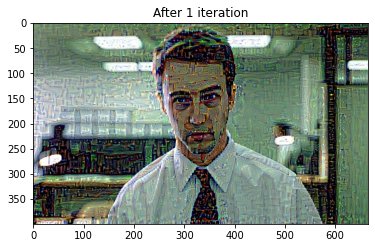

In [ ]:
plt.imshow(plt.imread('/content/drive/MyDrive/NeuralStyleWorkDir/neural_style_0.png'))
plt.title('After 1 iteration')

Text(0.5, 1.0, 'After 10 iterations')

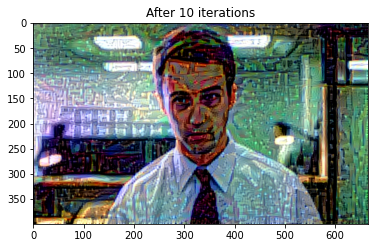

In [ ]:
plt.imshow(plt.imread('/content/drive/MyDrive/NeuralStyleWorkDir/neural_style_9.png'))
plt.title('After 10 iterations')

Text(0.5, 1.0, 'After 15 iterations')

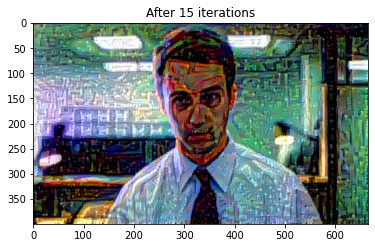

In [ ]:
plt.imshow(plt.imread('/content/drive/MyDrive/NeuralStyleWorkDir/neural_style_14.png'))
plt.title('After 15 iterations')

### Result 2 : Vgg19 without last conv block with Picasso style on image from Fight Club

Text(0.5, 1.0, 'After 1 iteration')

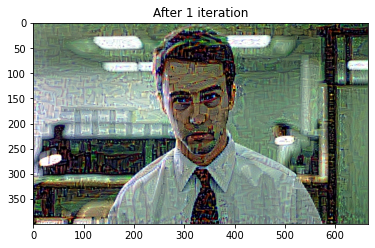

In [ ]:
plt.imshow(plt.imread('/content/drive/MyDrive/neural_style_changed_vgg_0.png'))
plt.title('After 1 iteration')

Text(0.5, 1.0, 'After 10 iteration')

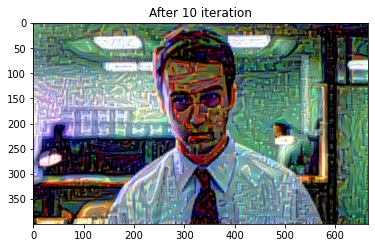

In [ ]:
plt.imshow(plt.imread('/content/drive/MyDrive/neural_style_changed_vgg_9.png'))
plt.title('After 10 iteration')

Text(0.5, 1.0, 'After 15 iteration')

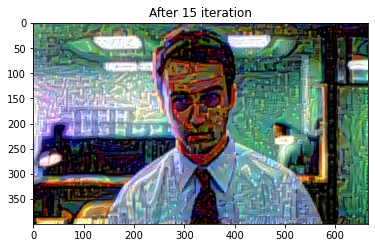

In [ ]:
plt.imshow(plt.imread('/content/drive/MyDrive/neural_style_changed_vgg_14.png'))
plt.title('After 15 iteration')

## Conclusion: reducing the number of layers (zeroing last convolutions) leads to a loss of style transfer clarity

### Result 3: Vgg19 full with Frida Kaglo style(on Fight Club)






Text(0.5, 1.0, 'After 1 iteration')

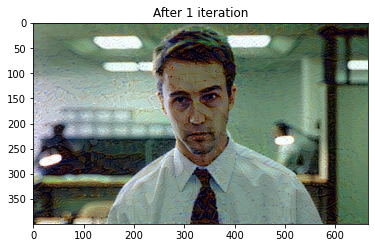

In [ ]:
plt.imshow(plt.imread('/content/drive/MyDrive/NeuralStyleWorkDir/neural_style_fc_and_fk_0.png'))
plt.title('After 1 iteration')

Text(0.5, 1.0, 'After 10 iteratios')

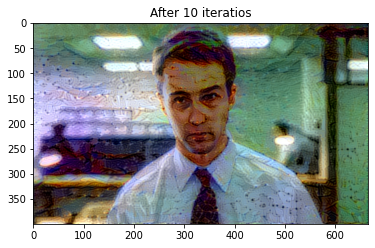

In [ ]:
plt.imshow(plt.imread('/content/drive/MyDrive/NeuralStyleWorkDir/neural_style_fc_and_fk_9.png'))
plt.title('After 10 iteratios')

Text(0.5, 1.0, 'After 15 iteratios')

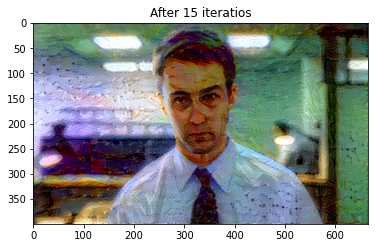

In [ ]:
plt.imshow(plt.imread('/content/drive/MyDrive/NeuralStyleWorkDir/neural_style_fc_and_fk_14.png'))
plt.title('After 15 iteratios')

### Result 4: Vgg19 full with Frida Kaglo style(on Paris)


Text(0.5, 1.0, 'After 1 iteration')

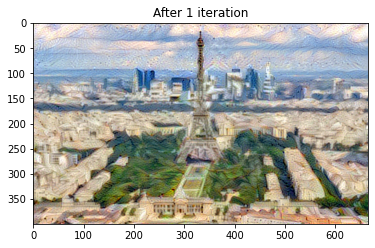

In [ ]:
plt.imshow(plt.imread("/content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_fk_0.png"))
plt.title('After 1 iteration')

Text(0.5, 1.0, 'After 10 iteration')

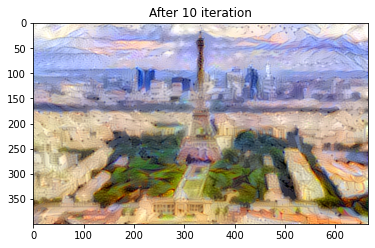

In [ ]:
plt.imshow(plt.imread("/content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_fk_9.png"))
plt.title('After 10 iteration')

Text(0.5, 1.0, 'After 15 iteration')

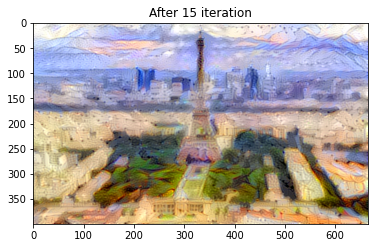

In [ ]:
plt.imshow(plt.imread("/content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_fk_14.png"))
plt.title('After 15 iteration')

### Result 5: Vgg19 full with Pablo Picasso style(on Paris)


Text(0.5, 1.0, 'After 1 iteration')

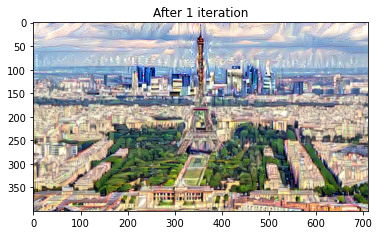

In [ ]:
plt.imshow(plt.imread("/content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_pp_0.png"))
plt.title('After 1 iteration')

Text(0.5, 1.0, 'After 10 iteration')

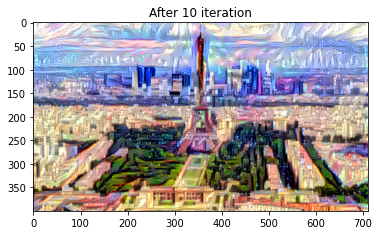

In [ ]:
plt.imshow(plt.imread("/content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_pp_9.png"))
plt.title('After 10 iteration')

Text(0.5, 1.0, 'After 15 iteration')

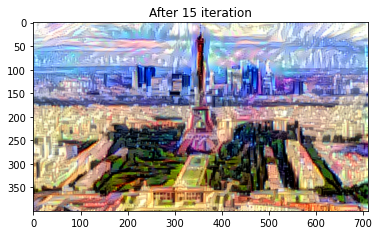

In [ ]:
plt.imshow(plt.imread("/content/drive/MyDrive/NeuralStyleWorkDir/neural_style_paris_and_pp_14.png"))
plt.title('After 15 iteration')

## Total: neural transfer algorithms are able to transfer the style of some images to others, and, using powerful networks (like vgg 19), it is possible to do this in a small number of iterations